We will now import all the libraries needed for training process. It will use Tensorflow backend and keras at frontend.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


We wil use datadir as the name given to the folder itself and take the parameters itself. Using head, we will show the first five values for the CSV on the desired format.

In [2]:
dir = "/Users/asik/Desktop/SelfDrivingCar"
columns = ["center", "left", "right", "steering", "throttle", "reverse", "speed"]
data = pd.read_csv(os.path.join(dir, "driving_log.csv"), names=columns)
pd.set_option("display.max_colwidth", -1)
data.head()

center  \
0  /Users/asik/Desktop/Self Driving Car/IMG/center_2021_12_19_18_46_10_430.jpg   
1  /Users/asik/Desktop/Self Driving Car/IMG/center_2021_12_19_18_46_10_551.jpg   
2  /Users/asik/Desktop/Self Driving Car/IMG/center_2021_12_19_18_46_10_723.jpg   
3  /Users/asik/Desktop/Self Driving Car/IMG/center_2021_12_19_18_46_10_830.jpg   
4  /Users/asik/Desktop/Self Driving Car/IMG/center_2021_12_19_18_46_10_980.jpg   

                                                                         left  \
0   /Users/asik/Desktop/Self Driving Car/IMG/left_2021_12_19_18_46_10_430.jpg   
1   /Users/asik/Desktop/Self Driving Car/IMG/left_2021_12_19_18_46_10_551.jpg   
2   /Users/asik/Desktop/Self Driving Car/IMG/left_2021_12_19_18_46_10_723.jpg   
3   /Users/asik/Desktop/Self Driving Car/IMG/left_2021_12_19_18_46_10_830.jpg   
4   /Users/asik/Desktop/Self Driving Car/IMG/left_2021_12_19_18_46_10_980.jpg   

                                                                         right  \
0   /Users/asik/Desktop/Self Driving Car/IMG/right_2021_12_19_18_46_10_430.jpg   
1   /Users/asik/Desktop/Self Driving Car/IMG/right_2021_12_19_18_46_10_551.jpg   
2   /Users/asik/Desktop/Self Driving Car/IMG/right_2021_12_19_18_46_10_723.jpg   
3   /Users/asik/Desktop/Self Driving Car/IMG/right_2021_12_19_18_46_10_830.jpg   
4   /Users/asik/Desktop/Self Driving Car/IMG/right_2021_12_19_18_46_10_980.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.000079  
1  0.0       0.0       0.0      0.000079  
2  0.0       0.0       0.0      0.000080  
3  0.0       0.0       0.0      0.000080  
4  0.0       0.0       0.0      0.000079

As this is picking up the entire path from the local machine, we need to use ntpath function to get the network path assigned. We will declare a name path_leaf and assign accordingly.

In [3]:
def pathleaf(path):
    head, tail = ntpath.split(path)
    return tail

data["center"] = data["center"].apply(pathleaf)
data["left"] = data["left"].apply(pathleaf)
data["right"] = data["right"].apply(pathleaf)
data.head()

center                              left  \
0  center_2021_12_19_18_46_10_430.jpg  left_2021_12_19_18_46_10_430.jpg   
1  center_2021_12_19_18_46_10_551.jpg  left_2021_12_19_18_46_10_551.jpg   
2  center_2021_12_19_18_46_10_723.jpg  left_2021_12_19_18_46_10_723.jpg   
3  center_2021_12_19_18_46_10_830.jpg  left_2021_12_19_18_46_10_830.jpg   
4  center_2021_12_19_18_46_10_980.jpg  left_2021_12_19_18_46_10_980.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2021_12_19_18_46_10_430.jpg  0.0       0.0       0.0      0.000079  
1  right_2021_12_19_18_46_10_551.jpg  0.0       0.0       0.0      0.000079  
2  right_2021_12_19_18_46_10_723.jpg  0.0       0.0       0.0      0.000080  
3  right_2021_12_19_18_46_10_830.jpg  0.0       0.0       0.0      0.000080  
4  right_2021_12_19_18_46_10_980.jpg  0.0       0.0       0.0      0.000079

We will bin the number of values where the number will be equal to 25 (odd number aimed to get center distribution). We will see the histogram using the np.histogram option on data frame ‘steering’, we will divide it to the number of bins. We keep samples at 400 and then we draw a line. We see the data is centered along the middle that is 0.

In [4]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data["steering"], num_bins)
print(bins)

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


Plot on it

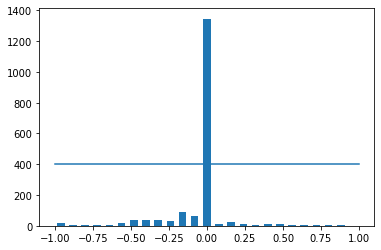

In [5]:
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot(
    (np.min(data["steering"]), np.max(data["steering"])),
    (samples_per_bin, samples_per_bin),
)


In [6]:
print("Total Data:", len(data))

Total Data: 1795


We wil specify a variable rove_list.We will specify samples we want to remove using looping construct through every single bin we will iterate through all the steering data. We will shuffle the data and romve some from it as it is now uniformly structured after shuffling.The output will be the distribution of steering angle that are much more uniform. There are significant amount of left steering angle and right steering angle eliminating the bias to drive straight all the time.

In [7]:
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data["steering"])):
        if data["steering"][i] >= bins[j] and data["steering"][i] <= bins[j + 1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
print("Removed:", len(remove_list))

Removed: 945


In [8]:
data.drop(data.index[remove_list], inplace=True)

In [9]:
print("Remaining:", len(data))

Remaining: 850


Plot on it

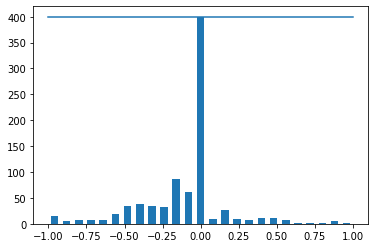

In [10]:
hist, _ = np.histogram(data["steering"], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot(
    (np.min(data["steering"]), np.max(data["steering"])),
    (samples_per_bin, samples_per_bin),
)

In [11]:
print(data.iloc[1])

center      center_2021_12_19_18_46_10_980.jpg
left        left_2021_12_19_18_46_10_980.jpg  
right       right_2021_12_19_18_46_10_980.jpg 
steering    0.0                               
throttle    0.0                               
reverse     0.0                               
speed       0.000079                          
Name: 4, dtype: object


We will now load the image into array to manipulate them accordingly. We will define a function named locd_img_steering. We will have image path as empty list and steering as empty list and then loop through. We use iloc selector as data frame based on the specific index we will use cut data for now.

In [12]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        image_path.append(os.path.join(datadir, left.strip()))
        steering.append(float(indexed_data[3]) + 0.15)
        image_path.append(os.path.join(datadir, right.strip()))
        steering.append(float(indexed_data[3]) - 0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

We will be splitting the image path as well as storing arrays accordingly.

In [13]:
image_paths, steerings = load_img_steering(dir + "/IMG", data)
X_train, X_valid, y_train, y_valid = train_test_split(
    image_paths, steerings, test_size=0.2, random_state=6
)
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))


Training Samples: 2040
Valid Samples: 510


We will have the histograms now.

Text(0.5, 1.0, 'Validation set')

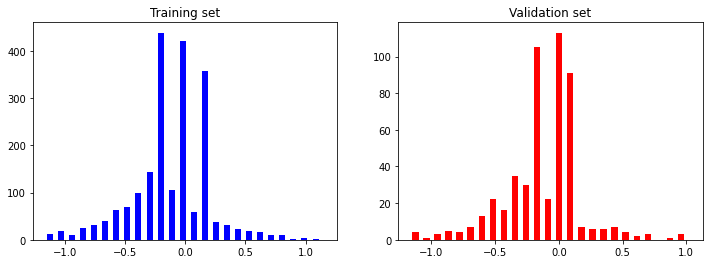

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color="blue")
axes[0].set_title("Training set")
axes[1].hist(y_valid, bins=num_bins, width=0.05, color="red")
axes[1].set_title("Validation set")

In the next steps, we normalize the data and in the nvdia model, we will have to keep it in a UAV pattern as well as slice unnecessary information. We preprocess the image too.

Zoom.The images in the dataset have relevant features in the lower part where the road is visible. The external environment above a certain image portion will never be used to determine the output and thus can be cropped. Approximately, 30% of the top portion of the image is cut and passed in the training set. The snippet of code and transformation of an image after cropping and resizing it to original image can be seen in below.

Text(0.5, 1.0, 'Zoomed Image')

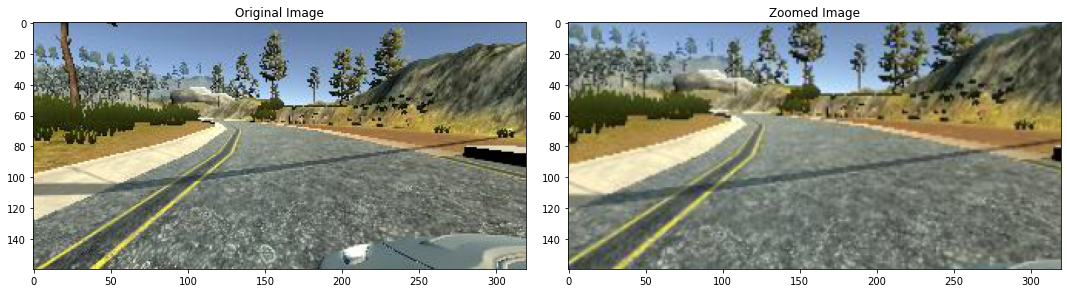

In [16]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(zoomed_image)
axs[1].set_title("Zoomed Image")

Shift(horizontal/vertical).The image is shifted by a small amount, it is vertical shift and horizontal shift as below.

Text(0.5, 1.0, 'Panned Image')

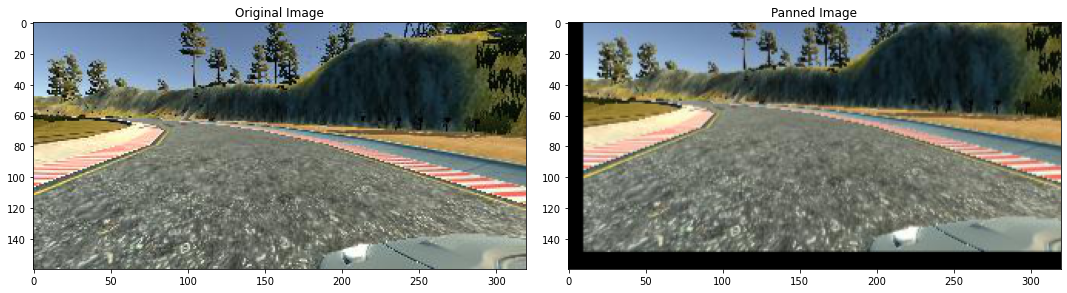

In [19]:
def pan(image):
    pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(panned_image)
axs[1].set_title("Panned Image")

Brightness.To generalize to the weather conditions with bright sunny day or cloudy, lowlight conditions, the brightness augmentation can prove to be very useful. The code snippet and increase of brightness can be seen below. Similarly, I have randomly also lowered down the level of brightness for other conditions.

Text(0.5, 1.0, 'Brightness altered image ')

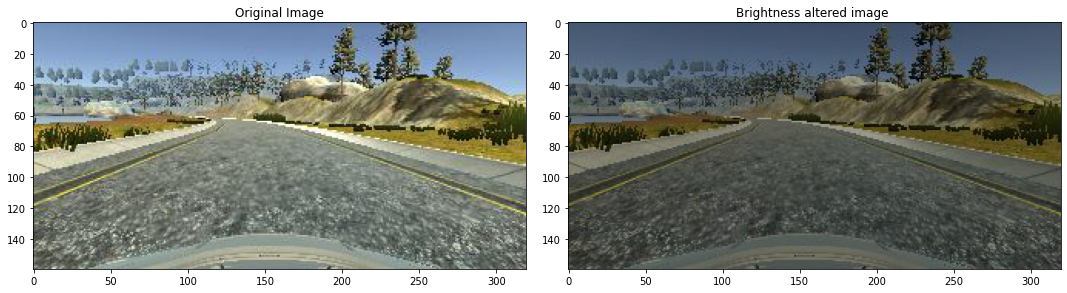

In [21]:
def random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(brightness_altered_image)
axs[1].set_title("Brightness altered image ")

Flip(horizontal).The image is flipped horizontally (i.e. a mirror image of the original image is passed to the dataset). The motive behind this is that the model gets trained for similar kinds of turns on opposite sides too. This is important because Track 1 includes only left turns. The snippet of code and transformation of an image after flipping it can be seen in below. 

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.15')

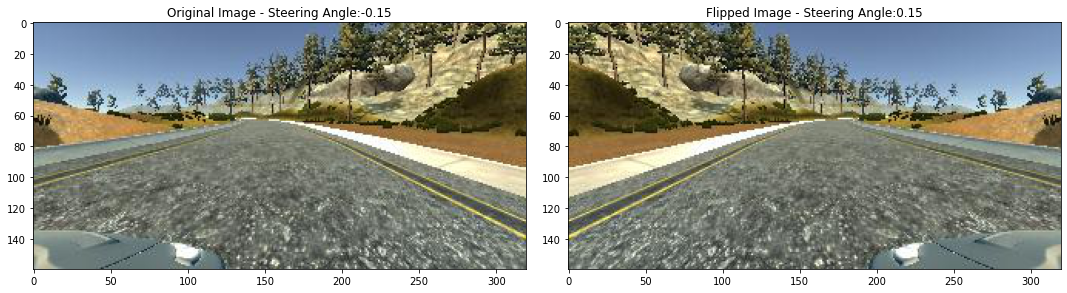

In [24]:
def random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle


random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image - " + "Steering Angle:" + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title("Flipped Image - " + "Steering Angle:" + str(flipped_steering_angle))

To have a look what we have at this moment

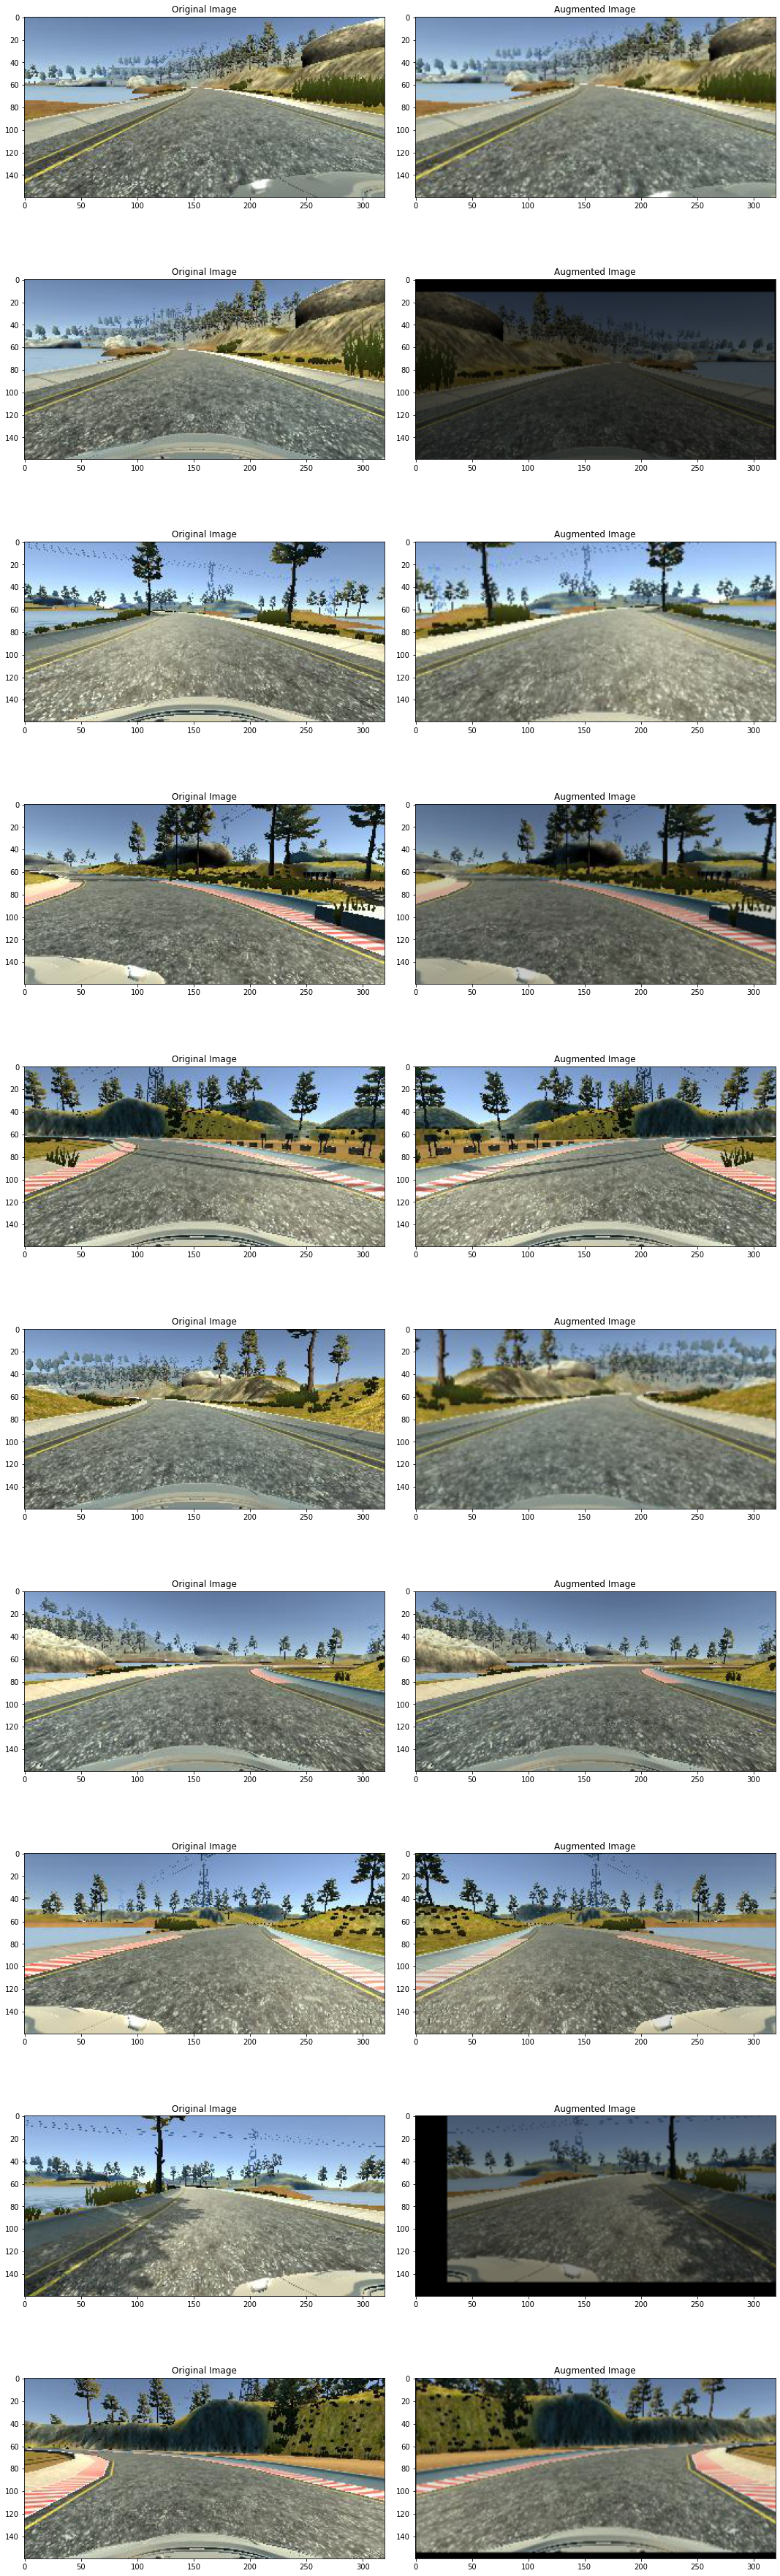

In [38]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = random_flip(image, steering_angle)
    return image, steering_angle


ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)

    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")

    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

I continued by doing some image processing. I cropped the image to remove the unnecessary features, changes the images to YUV format, used gaussian blur, decreased the size for easier processing and normalized the values.

In [41]:
def img_preprocess(img):
    ## Crop image to remove unnecessary features
    img = img[60:135, :, :]
    ## Change to YUV image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    ## Gaussian blur
    img = cv2.GaussianBlur(img, (3, 3), 0)
    ## Decrease size for easier processing
    img = cv2.resize(img, (200, 66))
    ## Normalize values
    img = img / 255
    return img

To compare and visualize I plotted the original and the pre-processed image.

Text(0.5, 1.0, 'Preprocessed Image')

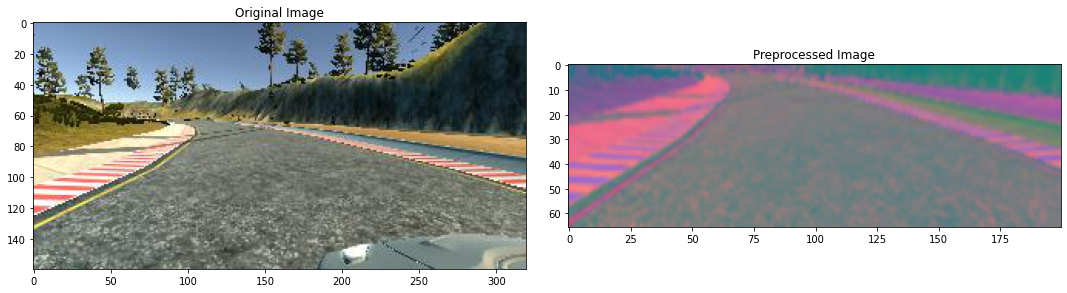

In [42]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(preprocessed_image)
axs[1].set_title("Preprocessed Image")

In [43]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)

            if istraining:
                im, steering = random_augment(
                    image_paths[random_index], steering_ang[random_index]
                )

            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)

        yield (np.asarray(batch_img), np.asarray(batch_steering))


So far so good. Next, I converted all the images into numpy array

Text(0.5, 1.0, 'Validation Image')

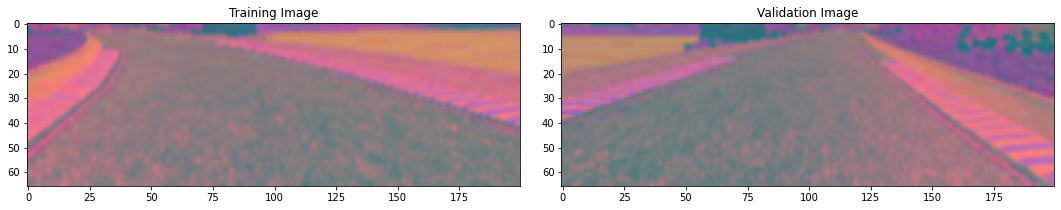

In [44]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title("Training Image")

axs[1].imshow(x_valid_gen[0])
axs[1].set_title("Validation Image")

We will design our Model architecture. We have to classify the traffic signs too that's why we need to shift from Lenet 5 model to NVDIA model. With behavioural cloning, our dataset is much more complex then any dataset we have used. We are dealing with images that have (200,66) dimensions. Our current datset has 5386 images to train with but MNSIT has around 60,000 images to train with. Our behavioural cloning code has simply has to return appropriate steering angle which is a regression type example. For these things, we need a more advanced model which is provided by nvdia and known as nvdia model.

![title](https://www.researchgate.net/profile/Mathew-Monfort/publication/301648615/figure/fig4/AS:357938163142666@1462350516717/CNN-architecture-The-network-has-about-27-million-connections-and-250-thousand.png)

For defining the model architecture, we need to define the model object. Normalization state can be skipped as we have already normalized it. We will add the convolution layer. As compared to the model, we will organize accordingly. The Nvdia model uses 24 filters in the layer along with a kernel of size 5,5. We will introduce sub sampling. The function reflects to stride length of the kernel as it processes through an image, we have large images. Horizontal movement with 2 pixels at a time, similarly vertical movement to 2 pixels at a time. As this is the first layer, we have to define input shape of the model too i.e., (66,200,3) and the last function is an activation function that is “elu”.

Revisting the model, we see that our second layer has 36 filters with kernel size (5,5) same subsampling option with stride length of (2,2) and conclude this layer with activation ‘elu’.

According to Nvdia model, it shows we have 3 more layers in the convolutional neural network. With 48 filters, with 64 filters (3,3) kernel 64 filters (3,3) kernel Dimensions have been reduced significantly so for that we will remove subsampling from 4th and 5th layer.

Next we add a flatten layer. We will take the output array from previous convolution neural network to convert it into a one dimensional array so that it can be fed to fully connected layer to follow.

Our last convolution layer outputs an array shape of (1,18) by 64.

We end the architecture of Nvdia model with a dense layer containing a single output node which will output the predicted steering angle for our self driving car. Now we will use model.compile() to compile our architecture as this is a regression type example the metrics that we will be using will be mean squared error and optimize as Adam. We will be using relatively a low learning rate that it can help on accuracy. We will use dropout layer to avoid overfitting the data. Dropout Layer sets the input of random fraction of nodes to “0” during each update. During this, we will generate the training data as it is forced to use a variety of combination of nodes to learn from the same data. We will have to separate the convolution layer from fully connected layer with a factor of 0.5 is added so it converts 50 percent of the input to 0. We Will define the model by calling the nvdia model itself. Now we will have the model training process.To define training parameters, we will use model.fit(), we will import our training data X_Train, training data ->y_train, we have less data on the datasets we will require more epochs to be effective. We will use validation data and then use Batch size.

In [48]:
def NvidiaModel():
  model = Sequential()
  model.add(Convolution2D(24,(5,5),strides=(2,2),input_shape=(66,200,3),activation="elu"))
  model.add(Convolution2D(36,(5,5),strides=(2,2),activation="elu"))
  model.add(Convolution2D(48,(5,5),strides=(2,2),activation="elu")) 
  model.add(Convolution2D(64,(3,3),activation="elu"))   
  model.add(Convolution2D(64,(3,3),activation="elu"))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(50,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(10,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.compile(optimizer=Adam(lr=1e-3),loss="mse")
  return model

In [49]:
model = NvidiaModel()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [50]:
history = model.fit_generator(
    batch_generator(X_train, y_train, 100, 1),
    steps_per_epoch=300,
    epochs=10,
    validation_data=batch_generator(X_valid, y_valid, 100, 0),
    validation_steps=200,
    verbose=1,
    shuffle=1,
)

Epoch 1/10
300/300 [==============================] - 317s 1s/step - loss: 0.1311 - val_loss: 0.0751
Epoch 2/10
300/300 [==============================] - 260s 867ms/step - loss: 0.0958 - val_loss: 0.0780
Epoch 3/10
300/300 [==============================] - 252s 842ms/step - loss: 0.0936 - val_loss: 0.0624
Epoch 4/10
300/300 [==============================] - 266s 890ms/step - loss: 0.0900 - val_loss: 0.0681
Epoch 5/10
300/300 [==============================] - 250s 836ms/step - loss: 0.0890 - val_loss: 0.0679
Epoch 6/10
300/300 [==============================] - 263s 877ms/step - loss: 0.0876 - val_loss: 0.0659
Epoch 7/10
300/300 [==============================] - 256s 854ms/step - loss: 0.0856 - val_loss: 0.0676
Epoch 8/10
300/300 [==============================] - 230s 769ms/step - loss: 0.0834 - val_loss: 0.0681
Epoch 9/10
300/300 [==============================] - 239s 799ms/step - loss: 0.0844 - val_loss: 0.0685
Epoch 10/10
300/300 [==============================] - 238s 796ms/s

We can have dead relu this is when a node in neural network essentially dies and only feeds a value of zero to nodes which follows it. We will change from relu to elu. Elu function has always a chance to recover and fix it errors means it is in a process of learning and contributing to the model. We will plot the model and then save it accordingly in h5 format for a keras file.

Text(0.5, 0, 'Epoch')

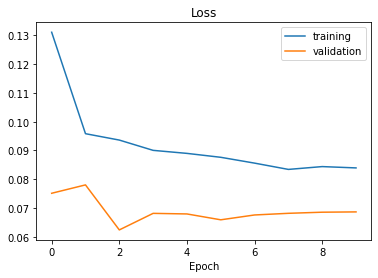

In [51]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["training", "validation"])
plt.title("Loss")
plt.xlabel("Epoch")

Save model

In [52]:
model.save('model.h5')